In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
autoencoder = tf.keras.models.load_model('autoencoder_covid_384x512_best_so_far')

In [3]:
layer_names = []
for i in range(1,8):
    layer_names.append('conv2d_' + str(i))

## Latent Space Model

In [4]:
latent_model = tf.keras.models.Model(inputs = autoencoder.input, outputs = autoencoder.get_layer('conv2d_7').output)

## Load Latent Features

In [5]:
from PIL import Image
import os
import numpy as np

In [6]:
def get_latent_feature(train = True):
    h = 384
    w = 512
    if train:
        folder = os.path.join('COVID_DATASET', 'train')
    else:
        folder = os.path.join('COVID_DATASET', 'validation')
    
    # get files
    iscovid_folder  = os.path.join(folder, 'covid')
    noncovid_folder = os.path.join(folder, 'noncovid')
    #
    iscovid_files  = os.listdir(iscovid_folder)
    noncovid_files = os.listdir(noncovid_folder)
    #
    iscovid_files  = [os.path.join(iscovid_folder, file) for file in iscovid_files]
    noncovid_files = [os.path.join(noncovid_folder, file) for file in noncovid_files]
    
    # get covid features
    iscovid_features  = np.zeros((len(iscovid_files), latent_model.output.shape[-1]))
    y_is = np.zeros((len(iscovid_files),))
    for i, file in enumerate(iscovid_files):
        img = np.array(Image.open(file).resize((w, h)))
        if len(img.shape) > 2:
            img = img[:, :, 0]
        else:
            pass
        img = np.expand_dims(img, 0)
        img = np.expand_dims(img, -1)
        iscovid_features[i] = latent_model.predict(img).squeeze()
    # get noncovid features
    noncovid_features = np.zeros((len(noncovid_files), latent_model.output.shape[-1]))
    y_no = np.ones((len(noncovid_files),))
    for i, file in enumerate(noncovid_files):
        img = np.array(Image.open(file).resize((w, h)))
        if len(img.shape) > 2:
            img = img[:, :, 0]
        else:
            pass
        img = np.expand_dims(img, 0)
        img = np.expand_dims(img, -1)
        noncovid_features[i] = latent_model.predict(img).squeeze()
    
    return (iscovid_features, noncovid_features, y_is, y_no)

In [7]:
x_covid, x_noncovid, y_covid, y_non_covid = get_latent_feature()

In [8]:
x1, x2, y1, y2 = get_latent_feature(False)

In [9]:
x_train, y_train = np.vstack((x_covid, x_noncovid)), np.hstack((y_covid, y_non_covid))
x_valid, y_valid = np.vstack((x1, x2)), np.hstack((y1, y2))

In [10]:
x_covid.shape, x_noncovid.shape

((231, 128), (273, 128))

In [11]:
x_train.shape, y_train.shape

((504, 128), (504,))

In [12]:
x_valid.shape, y_valid.shape

((200, 128), (200,))

## KNN

In [13]:
from sklearn.metrics import confusion_matrix

In [14]:
def accuracy(y, y_hat):
    return np.mean(y == y_hat)

class KNNClassifier():
    def fit(self, X, y):
        self.X = X
        self.y = y.astype(int)
    def predict(self, X, k, epsilon=1e-2):
        N = len(X)
        y_hat = np.zeros(N)
        for i in range(N):
            dist = np.sum((self.X - X[i])**2, axis=1) # find distance
            idx = np.argsort(dist)[:k] # get the data indexes whose distances are the closest
            ws = (np.sqrt(dist[idx]) + epsilon)**-1
            y_hat[i] = np.bincount(self.y[idx], weights=ws).argmax()
        return y_hat

In [15]:
knn = KNNClassifier()
knn.fit(x_train, y_train)

In [16]:
k = []
acc_is = []
acc_no = []
acc = []
for i in range(1, 10):
    k.append(i)
    pred = knn.predict(x_valid, i)
    acc.append(accuracy(y_valid, pred))
    acc_is.append(accuracy(y1, pred[0:len(y1)]))
    acc_no.append(accuracy(y2, pred[len(y1):]))

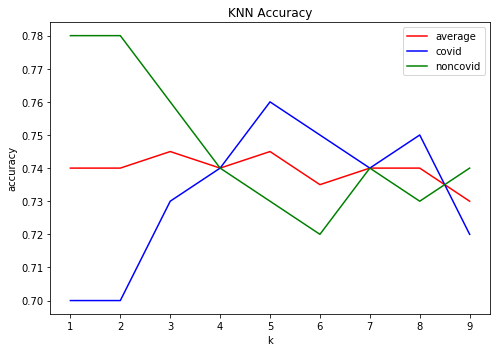

In [17]:
fig = plt.figure(figsize = (7, 5))
plt.plot(k, acc, label = 'average', color = 'red')
plt.plot(k, acc_is, label = 'covid', color = 'blue')
plt.plot(k, acc_no, label = 'noncovid', color = 'green')
plt.legend()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('KNN Accuracy')
plt.tight_layout()
fig.savefig('Knn_results', transparent = True)

In [18]:
pred = knn.predict(x_valid, 4)
cm = confusion_matrix(pred, y_valid)

In [19]:
import seaborn as sns

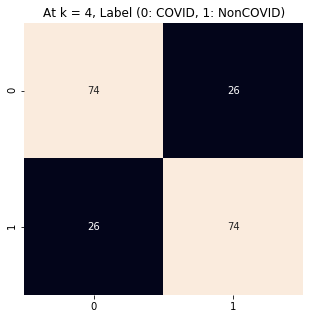

In [20]:
fig = plt.figure(figsize = (5, 5))
sns.heatmap(cm, annot = True, cbar = False)
plt.title('At k = 4, Label (0: COVID, 1: NonCOVID)')
fig.savefig('Knn_at_4_confusion', transparent = True)

## Bayesian model

In [21]:
from scipy.stats import multivariate_normal as mvn

In [22]:
class GaussNB():
    ''' Description
    This is a supervised learning algorithm, Gaussian Naive Bayes.
    In fit function:
        The model learns the  knowledge(MEANS and VARIANCES)
            from the dataset, and uses the knowledge to predict new data.
        EACH data sample contains:
            an input and a label, where the input is
            a set of features, such as [x1,x2,...xi...],
            let's say there are 1000 features for each sample.
        For EACH category:
            the model learns A, B, and Prior
            where A is the mean features which has the
            same length as a sample, 1000.
            where B is the variance features which also 
            has the same length as a sample, 1000.
            The Prior = (# of samples in this category)/(entire dataset)
        Thus, K categories, K As, K Bs, and K Priors.
        The model uses As, Bs, and Priors to predict new samples.
    In predict funcion:
        mvn stands for multivariate normal/Gaussian.
        Let's say we have 800 new samples.
        For EACH category:
            the mvn generates 800 probabilities/scores.
        Thus, we get 800 by K probabilities, where K is
            the number of the categories.
        For each row:
            we find the index of the max probability,
            so the category we want to assign to the sample
            is that index.
    '''
    def fit(self, X, y, epsilon=1e-3):
        self.likelihoods = dict()
        self.priors = dict()
        self.K = set(y.astype(int))
        for k in self.K:
            X_k = X[y==k,:]
            self.likelihoods[k] = {'means': X_k.mean(axis=0),\
                                   'cov': X_k.var(axis=0)+epsilon}
            self.priors[k] = len(X_k)/len(X)
            
    def predict(self, X, return_prob=False):
        N, D = X.shape
        P_hat = np.zeros((N, len(self.K)))
        for k, l in self.likelihoods.items():
            P_hat[:,k] = mvn.logpdf(X, l['means'], l['cov']) + np.log(self.priors[k])
        if return_prob:
            P_hat
        else:
            return np.argmax(P_hat, axis=1).astype(int)
    
    def get_confusion(self, X, y):
        n = len(self.K)
        confusion_matrix = np.zeros((n,n))
        for k in range(n):
            y_hat = self.predict(X[y==k])
            for j in range(n):
                confusion_matrix[k,j] = sum(y_hat==j)
            confusion_matrix[k] = confusion_matrix[k]/sum(confusion_matrix[k])
        return np.round(confusion_matrix,2)

In [23]:
class GenGaussNB():
    ''' Description
    This is a supervised learning algorithm, Gaussian Naive Bayes.
    In fit function:
        The model learns the  knowledge(MEANS and COVARIANCE MATRIXES)
            from the dataset, and uses the knowledge to predict new data.
        EACH data sample contains:
            an input and a label, where the input is
            a set of features, such as [x1,x2,...xi...],
            let's say there are 1000 features for each sample.
        For EACH category:
            the model learns A, B, and Prior
            where A is the mean features which has the
            same length as a sample, 1000.
            where B is covariance matrix, 1000x1000.
            The Prior = (# of samples in this category)/(entire dataset)
        Thus, K categories, K As, K Bs, and K Priors.
        The model uses As, Bs, and Priors to predict new samples.
    In predict funcion:
        mvn stands for multivariate normal/Gaussian.
        Let's say we have 800 new samples.
        For EACH category:
            the mvn generates 800 probabilities/scores.
        Thus, we get 800 by K probabilities, where K is
            the number of the categories.
        For each row:
            we find the index of the max probability,
            so the category we want to assign to the sample
            is that index.
    '''
    def fit(self, X, y, epsilon=0.1):
        self.likelihoods = dict()
        self.priors = dict()
        self.K = set(y.astype(int))
        for k in self.K:
            X_k = X[y==k,:]
            self.likelihoods[k] = {'means': X_k.mean(axis=0)} # calculate mean
            # calculate covariance matrix
            g = X_k-self.likelihoods[k]['means']
            self.likelihoods[k]['cov'] = (1/(len(X_k)-1))*np.matmul(g.T,g)+epsilon*np.eye(X_k.shape[1]) 
            self.priors[k] = len(X_k)/len(X)
    
    def predict(self, X, return_prob=False):
        N, D = X.shape
        P_hat = np.zeros((N, len(self.K)))
        for k, l in self.likelihoods.items():
            P_hat[:,k] = mvn.logpdf(X, l['means'], l['cov']) + np.log(self.priors[k])
        if return_prob:
            return P_hat
        else:
            return np.argmax(P_hat, axis=1).astype(int)
    
    def get_confusion(self, X, y):
        n = len(self.K)
        conf_matrix = np.zeros((n,n))
        for i in range(n):
            y_hat = self.predict(X[y==i])
            for j in range(n):
                conf_matrix[i,j] = sum(y_hat==j)
            conf_matrix[i] = conf_matrix[i]/sum(conf_matrix[i])
        return np.round(conf_matrix,2)

In [24]:
gnb = GenGaussNB()
epsilon = []
acc = []
acc_is = []
acc_no = []
for i in range(10):
    gnb.fit(x_train, y_train, epsilon = 10**i)
    epsilon.append(i)
    pred = gnb.predict(x_valid)
    acc.append(accuracy(y_valid, pred))
    acc_is.append(accuracy(y1, pred[0:len(y1)]))
    acc_no.append(accuracy(y2, pred[len(y1):]))

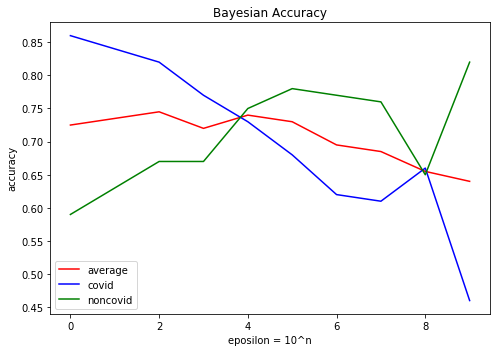

In [25]:
fig = plt.figure(figsize = (7, 5))
plt.plot(epsilon, acc, label = 'average', color = 'red')
plt.plot(epsilon, acc_is, label = 'covid', color = 'blue')
plt.plot(epsilon, acc_no, label = 'noncovid', color = 'green')
plt.legend()
plt.xlabel('eposilon = 10^n')
plt.ylabel('accuracy')
plt.title('Bayesian Accuracy')
plt.tight_layout()
fig.savefig('Bayesian_results', transparent = True)

In [26]:
gnb.fit(x_train, y_train, epsilon = 10**1)
pred = gnb.predict(x_valid)
accuracy(y_valid, pred)

0.735

In [27]:
gnb.fit(x_train, y_train, epsilon = 10**4)
pred = gnb.predict(x_valid)
cm = confusion_matrix(pred, y_valid)

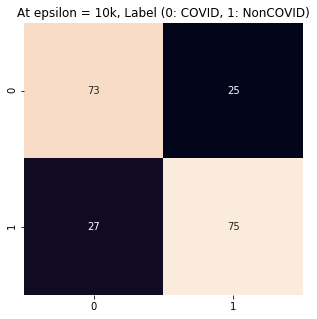

In [28]:
fig = plt.figure(figsize = (5, 5))
sns.heatmap(cm, annot = True, cbar = False)
plt.title('At epsilon = 10k, Label (0: COVID, 1: NonCOVID)')
fig.savefig('Bayesian_at_4_confusion', transparent = True)